# Multiclass classification
In this notebook we will make a multiclass classification, the starting paper is as follows: [A Deep Learning Approach for Viral DNA Sequence Classification using Genetic Algorithm](https://www.researchgate.net/publication/363276607_A_Deep_Learning_Approach_for_Viral_DNA_Sequence_Classification_using_Genetic_Algorithm)

We will propose different models for the task on a different dataset


#### Definition of common import and functions


In [1]:
import json, os
import pandas as pd
import numpy as np

import keras

from keras.src.losses import SparseCategoricalCrossentropy
from keras.src.optimizers import Adamax, LossScaleOptimizer

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

df_path = './Dataset/MulticlassDatasets/'
df_saved = './Saved/'
epochs = 20
sequence_df = None

## Models

In [17]:
def get_model(dim, num_classes):
    inputs = keras.layers.Input(shape=dim)
    x = keras.layers.Masking(mask_value=-1.0)(inputs)
    x = keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.LSTM(768)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(256, kernel_regularizer='l2')(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs=inputs, outputs=x)
    return model


### Unbalanced data set loading

In [ ]:
df = None
with open(df_path+'UnBalancedDataset.jsonl') as f:
  for index, line in tqdm(enumerate(f)):
      data = json.loads(line)
      if df is None:
          df = pd.DataFrame(data=data, index=[0])
      else:
          df.loc[len(df)] = data
df.head()

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

In [ ]:
labels = df['Family']
X = df['Sequence']
X

I see the maximum length of the sequence so that I can make the dataset containing sequence and target

In [ ]:
max_len = []
for el in X:
    max_len.append(len(el))
max_len = max(max_len)
max_len

In [ ]:
cols =[]

for col in range(max_len):
    cols.append('nucleotide_' + str(col))


In [ ]:
def encoder_sequence(seq):
  if seq == 'A':
    return 1
  elif seq == 'C':
    return 2
  elif seq == 'G':
    return 3
  elif seq == 'T':
    return 4
  else:
    return -1

def decode_sequence(seq):
  if seq == 1:
    return 'A'
  elif seq == 2:
    return 'C'
  elif seq == 3:
    return 'G'
  elif seq == 4:
    return 'T'
  else:
    return None

In [ ]:
sequence_df = pd.DataFrame(columns = cols)

for row in tqdm(X):
    sequence = {}
    row = list(row)
    for index, i in enumerate(cols):
        if index < len(row):
            sequence[i] = encoder_sequence(row[index])
        else:
          sequence[i] = None

    sequence_df.loc[len(sequence_df)] = sequence

sequence_df.head()

In [ ]:
sequence_df['Target'] = labels
sequence_df.head()
sequence_df.to_json(df_path+'ProcessedUnBalancedDataset.jsonl', orient='records', lines=True)

In [3]:
# If all previous step are performed, skip to this cell
if os.path.exists(df_path+'ProcessedUnBalancedDataset.jsonl') and sequence_df is None:
    print('Loading data from ProcessedUnBalancedDataset.jsonl...')
    sequence_df = pd.read_json(df_path+'ProcessedUnBalancedDataset.jsonl', orient='records', lines=True)
else:
    print('Dataset or dataset already created not exists, run previous step.')

labels = sequence_df['Target']
X = sequence_df.drop(['Target'], axis=1)
X.head()

Loading data from ProcessedUnBalancedDataset.jsonl...


,nucleotide_0,nucleotide_1,nucleotide_2,nucleotide_3,nucleotide_4,nucleotide_5,nucleotide_6,nucleotide_7,nucleotide_8,nucleotide_9,...,nucleotide_3989,nucleotide_3990,nucleotide_3991,nucleotide_3992,nucleotide_3993,nucleotide_3994,nucleotide_3995,nucleotide_3996,nucleotide_3997,nucleotide_3998
0,1,4,3,3,1,4,3,4,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4,3,1,1,4,4,3,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,2,3,3,1,4,3,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,2,3,1,1,1,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,4,2,2,1,2,2,1,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
labels.value_counts()

Target
Geminiviridae       15183
Hepadnaviridae      11360
Orthomyxoviridae    11344
Circoviridae        10076
Name: count, dtype: int64

## Prepare last preprocessing steps

In [5]:
encoder_y = LabelEncoder()
scaler = MinMaxScaler()
X = X.to_numpy().astype(np.float32)
y = labels.to_numpy()

# fit the encoder for the label
encoder_y.fit(y)
# scaling the feature
X = scaler.fit_transform(X)

X.shape, y.shape

((47963, 3999), (47963,))

In [6]:
dimension = (X.shape[1], 1)
dimension

(3999, 1)

In [7]:
n_class = len(labels.unique())
# param for the model
batch_size = 32
n_class

4

In [18]:
model = get_model(dimension, n_class)
model.compile(
    optimizer=LossScaleOptimizer(
        Adamax(
        learning_rate=0.002,
        )
    ),
    loss=SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

D:\Vito\ML\venv\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3999, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_2 (Masking)             │ (None, 3999, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 3995, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1997, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1993, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 996, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 768)            │     2,755,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,998,020 (11.44 MB)

 Trainable params: 2,996,484 (11.43 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Continual learning
For fit the model we suse the technique of continual learning, so we split the dataset into n batch and 
we fit the model for every batch saving the most performant model.

In [19]:
n_batch = 10
start = 0
step = int(len(X)/n_batch) 
end = step

all_df = []

for i in range(n_batch):
    all_df.append(
        {
            'X': X[start:end],
            'y': y[start:end]
        }
    )
    start += step
    end += step

step, end

(4796, 52756)

In [ ]:
best_accuracy = 0
# best model to save
best_model = None

# metrics of the best classification for the evaluation of the best model
best_pred = None
gt_pred = None

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    verbose=1,
    mode="auto",
    start_from_epoch=0,
)

all_accuracy = []
all_loss = []
for df in all_df:
    X_f, X_test, y_f, y_test = train_test_split(df['X'], df['y'], test_size=0.2, random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1, random_state=42)
    
    X_train = np.nan_to_num(X_train, nan=-1.0)
    X_val = np.nan_to_num(X_val, nan=-1.0)
    X_test = np.nan_to_num(X_test, nan=-1.0)
    
    # reshape for three-dimensional space
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    y_train = encoder_y.transform(y_train).astype(np.float32)
    y_val = encoder_y.transform(y_val).astype(np.float32)
    y_test = encoder_y.transform(y_test).astype(np.float32)
    

    # fit the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping],
    )

    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    
    all_accuracy.append(acc)
    all_loss.append(loss)
    # get the prediction        
    y_pred = model.predict(X_test, verbose=0)
    y_pred = [np.argmax(y) for y in y_pred]
    y_pred = encoder_y.inverse_transform(y_pred)
    
    if acc > best_accuracy:
        print(f'Saving best model with Accuracy of {acc*100:.2f}%...')
        best_accuracy = acc
        best_model = model
        best_pred = y_pred
        gt_pred = y_test
    
# plot the fit metrics
fig, axes = plt.subplots(
                     ncols=2,
                     nrows=1,
)

ax1, ax2 = axes.flatten()
# summarize history for accuracy
ax1.plot(all_accuracy)
ax1.legend(['test'])
ax1.set_title('Accuracy')
ax2.plot(all_loss)
ax2.legend(['test'])
ax2.set_title('Loss')
fig.suptitle(f'Accuracy Stratified K fold')
fig.show()

In [23]:
sequence_df['Target'] = labels
test = pd.concat([
    sequence_df[sequence_df['Target'] == 'Geminiviridae'][:100],
    sequence_df[sequence_df['Target'] == 'Hepadnaviridae'][:100],
    sequence_df[sequence_df['Target'] == 'Orthomyxoviridae'][:100],
    sequence_df[sequence_df['Target'] == 'Circoviridae'][:100]
])

print(test.shape)

test = test.sample(frac=1).reset_index(drop=True)
y_test = test['Target'].to_numpy()
X = test.drop(['Target'],axis=1).to_numpy()
X = scaler.transform(X)
X = np.nan_to_num(X, nan=-1.0)
X = X.reshape(X.shape[0], X.shape[1], 1)

y_pred = best_model.predict(X, verbose=1)
y_pred = [np.argmax(y) for y in y_pred]
y_pred = encoder_y.inverse_transform(y_pred)

(400, 4000)


D:\Vito\ML\venv\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [24]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=0))

                  precision    recall  f1-score   support

    Circoviridae       1.00      0.01      0.02       100
   Geminiviridae       0.95      0.95      0.95       100
  Hepadnaviridae       0.96      0.97      0.97       100
Orthomyxoviridae       0.51      1.00      0.67       100

        accuracy                           0.73       400
       macro avg       0.85      0.73      0.65       400
    weighted avg       0.85      0.73      0.65       400



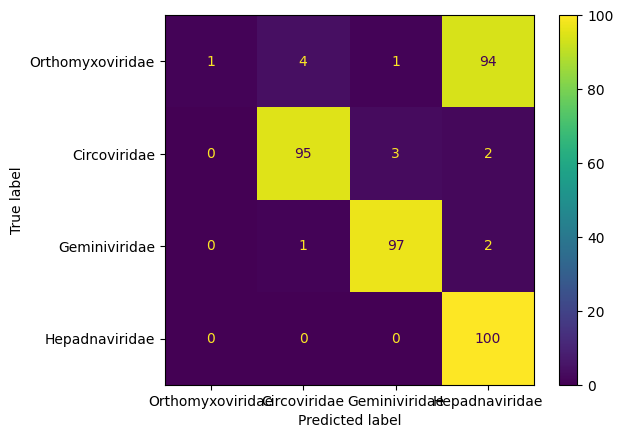

In [25]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels.unique()
)

disp.plot()

In [ ]:
# saving the best model
best_model.save(df_saved+'BestUnbalancedModelContinualLearning.keras')